In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

In [35]:
weather = pd.read_csv('../data/weather_final.csv')
weather = weather[weather['year'] >= 1992]

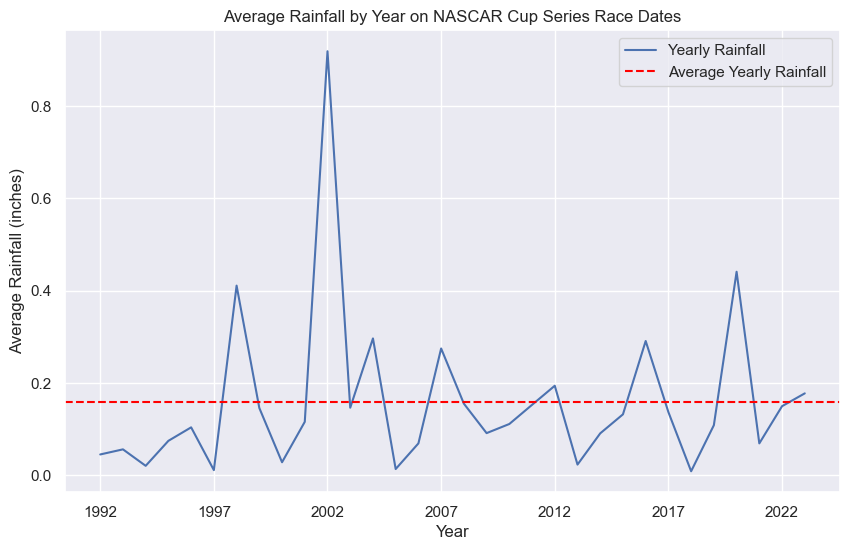

In [36]:
# Plot the average rain for each year with the date column

weather['date'] = pd.to_datetime(weather['date'])
weather['year'] = weather['date'].dt.year

plt.figure(figsize=(10, 6))
weather.groupby('year')['prcp'].mean().plot(label='Yearly Rainfall')
plt.title('Average Rainfall by Year on NASCAR Cup Series Race Dates')
plt.xlabel('Year')
plt.ylabel('Average Rainfall (inches)')
# Only show every 5 years on the x-axis
plt.xticks(weather['year'].unique()[::5])
# plot the average rain across all years
plt.axhline(weather.groupby('year')['prcp'].mean().mean(), color='red', linestyle='--', label='Average Yearly Rainfall')
plt.legend()
plt.show()

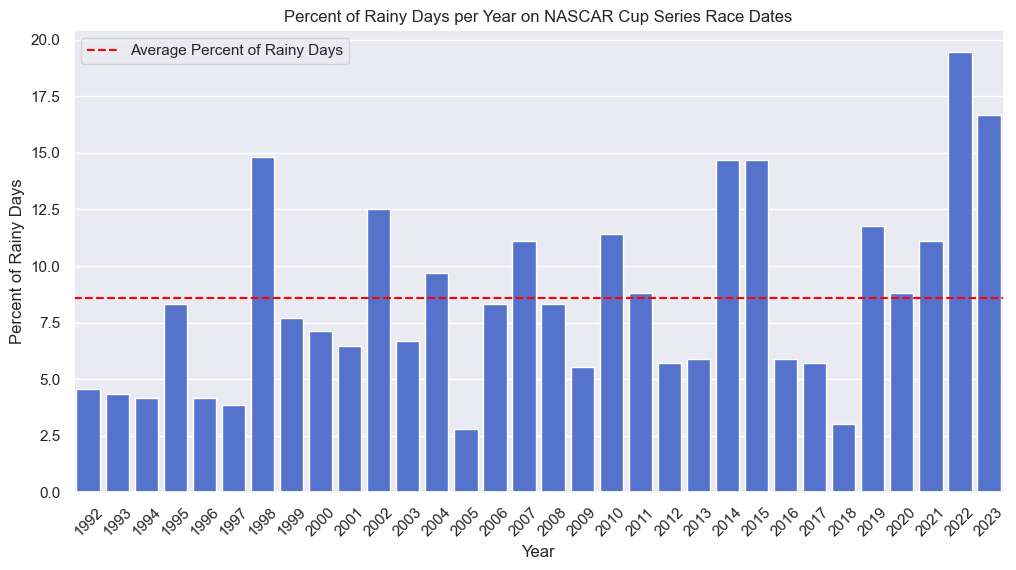

In [37]:
# create a bar plot that shows the count of rainy days per year

weather['rain_binary'] = weather['prcp'] > 0

weather_pct = weather.groupby('year')['rain_binary'].mean().reset_index()
weather_pct['rain_binary'] = weather_pct['rain_binary'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=weather_pct, x='year', y='rain_binary', color='royalblue')
plt.title('Percent of Rainy Days per Year on NASCAR Cup Series Race Dates')
plt.xlabel('Year')
plt.ylabel('Percent of Rainy Days')
plt.xticks(rotation=45)
# draw a line at the average percent of rainy days
plt.axhline(weather_pct['rain_binary'].mean(), color='red', linestyle='--', label='Average Percent of Rainy Days')
plt.legend()
plt.show()

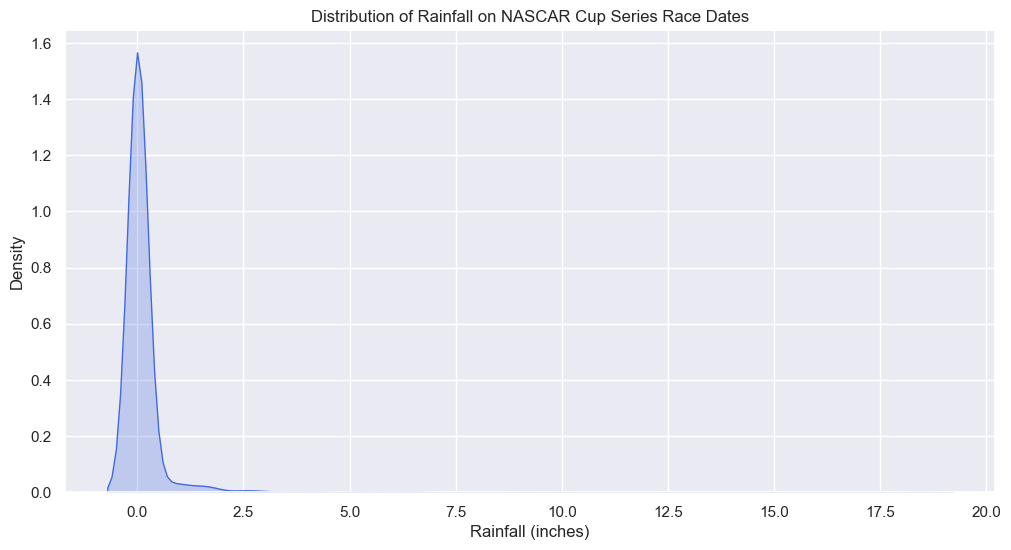

In [38]:
# print distribution of rain

plt.figure(figsize=(12, 6))
sns.kdeplot(data=weather, x='prcp', fill=True, color='royalblue')
plt.title('Distribution of Rainfall on NASCAR Cup Series Race Dates')
plt.xlabel('Rainfall (inches)')
plt.ylabel('Density')
plt.show()

In [39]:
weather['prcp'].describe()

count    1012.000000
mean        0.161858
std         0.939889
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        18.500000
Name: prcp, dtype: float64

In [40]:
race_summary = pd.read_csv('../data/race_summary.csv')

In [41]:
race_summary['miles_completed'] = race_summary['track_length'] * race_summary['laps']

In [42]:
# Find anomalous miles completed by grouping by the track and finding miles completed that are less than the median

for track in race_summary['track'].unique():
    temp_df = race_summary[race_summary['track'] == track]
    median_miles = temp_df['miles_completed'].median()
    anomalous_miles = temp_df[temp_df['miles_completed'] < median_miles]
    if not anomalous_miles.empty:
        print(f'Anomalous miles completed for {track}:')
        print(anomalous_miles[['season', 'miles_completed']])

Anomalous miles completed for Daytona International Speedway:
      season  miles_completed
14      1992            400.0
43      1993            400.0
73      1994            400.0
104     1995            400.0
135     1996            292.5
167     1997            400.0
213     1998            400.0
233     1999            400.0
267     2000            400.0
301     2001            400.0
337     2002            400.0
357     2003            272.5
373     2003            400.0
409     2004            400.0
445     2005            400.0
481     2006            400.0
518     2007            400.0
554     2008            405.0
573     2009            380.0
590     2009            400.0
626     2010            415.0
698     2012            400.0
734     2013            402.5
770     2014            280.0
805     2015            402.5
841     2016            402.5
877     2017            407.5
950     2019            317.5
994     2020            410.0
1030    2021            412.5
1066    

In [43]:
# For each track, find the two most common miles completed values

common_miles = {} # dictionary to store the two most common miles completed for each track

for track in race_summary['track'].unique():
    temp_df = race_summary[race_summary['track'] == track]
    miles_completed_counts = temp_df['miles_completed'].value_counts()
    # If there are less than two unique values, or the second value has only occured once, only store the most common value
    if len(miles_completed_counts) < 2 or miles_completed_counts.iloc[1] == 1:
        common_miles[track] = [miles_completed_counts.index[0]]
    else:
        common_miles[track] = miles_completed_counts.index[:2].tolist()

In [44]:
# Find anomalous miles completed by checking if the miles completed is not in the two most common values for the track

races_shortened = []
total_races_shortened = 0

for track in race_summary['track'].unique():
    temp_df = race_summary[race_summary['track'] == track]
    common_miles_track = common_miles[track]
    anomalous_miles = temp_df[~temp_df['miles_completed'].isin(common_miles_track)]
    for case in anomalous_miles['miles_completed']:
        if case > max(common_miles_track) or case >= .975 * max(common_miles_track) or case >= .975 * min(common_miles_track):
            anomalous_miles = anomalous_miles[anomalous_miles['miles_completed'] != case]
        elif len(anomalous_miles[anomalous_miles['miles_completed'] == case]) > 1:
            anomalous_miles = anomalous_miles[anomalous_miles['miles_completed'] != case]
    if anomalous_miles.shape[0] > 1:
        races_shortened.append(anomalous_miles[['season', 'track', 'miles_completed']])
        total_races_shortened += anomalous_miles.shape[0]
    if not anomalous_miles.empty:
        print(f'Anomalous miles completed for {track}:')
        print(anomalous_miles[['season', 'miles_completed']])
    
print(f'Total Races Shortened since 1992: {total_races_shortened}')

Anomalous miles completed for Daytona International Speedway:
     season  miles_completed
135    1996            292.5
357    2003            272.5
573    2009            380.0
770    2014            280.0
950    2019            317.5
Anomalous miles completed for Atlanta Motor Speedway:
      season  miles_completed
216     1998           340.34
353     2002           381.92
1095    2023           284.90
Anomalous miles completed for Darlington Raceway:
     season  miles_completed
221    1999          224.024
240    1999          368.820
974    2020          284.128
Anomalous miles completed for Martinsville Speedway:
      season  miles_completed
97      1995          187.256
1048    2022          211.978
1085    2023          210.400
Anomalous miles completed for Talladega Superspeedway:
      season  miles_completed
138     1996           343.14
1035    2021           311.22
Anomalous miles completed for Charlotte Motor Speedway:
     season  miles_completed
976    2020          

In [45]:
# Add a shortened column

race_summary['shortened'] = False

for track in races_shortened:
    for _, race in track.iterrows():
        race_summary.loc[(race_summary['season'] == race['season']) & (race_summary['track'] == race['track']) & (race_summary['miles_completed'] == race['miles_completed']), 'shortened'] = True

In [46]:
race_summary[race_summary['season'] == 2023]

race_summary[(race_summary['track'] == 'Texas Motor Speedway') & (race_summary['season'] == 2023) & race_summary['miles_completed'] == 400.5]['shortened'] = False
race_summary[(race_summary['track'] == 'Indianapolis Grand Prix Circuit') & (race_summary['season'] == 2022) & (race_summary['miles_completed'] == 209.754)]['shortened'] = False
race_summary[(race_summary['track'] == 'Indianapolis Grand Prix Circuit') & (race_summary['season'] == 2023) & (race_summary['miles_completed'] == 199.998)]['shortened'] = False

In [47]:
man_fin_1 = set(race_summary['manufacturer_finish_1'])
man_fin_2 = set(race_summary['manufacturer_finish_2'])
man_fin_3 = set(race_summary['manufacturer_finish_3'])
man_fin_4 = set(race_summary['manufacturer_finish_4'])
man_fin_5 = set(race_summary['manufacturer_finish_5'])

unique_manufacturers = man_fin_1.union(man_fin_2).union(man_fin_3).union(man_fin_4).union(man_fin_5)

In [48]:
# Create a count column for each manufacturer in race summary and count the top 5 finishes for each manufacturer for each race

for manufacturer in unique_manufacturers:
    race_summary[f'{manufacturer}_top5_count'] = 0

for _, row in race_summary.iterrows():
    for col in ['manufacturer_finish_1', 'manufacturer_finish_2', 'manufacturer_finish_3', 'manufacturer_finish_4', 'manufacturer_finish_5']:
        race_summary.loc[row.name, f'{row[col]}_top5_count'] += 1

race_summary[['manufacturer_finish_1', 'manufacturer_finish_2', 'manufacturer_finish_3', 'manufacturer_finish_4', 'manufacturer_finish_5', 'Pontiac_top5_count', 'Toyota_top5_count', 'Ford_top5_count', 'Chevrolet_top5_count', 'Dodge_top5_count', 'Oldsmobile_top5_count']]

,manufacturer_finish_1,manufacturer_finish_2,manufacturer_finish_3,manufacturer_finish_4,manufacturer_finish_5,Pontiac_top5_count,Toyota_top5_count,Ford_top5_count,Chevrolet_top5_count,Dodge_top5_count,Oldsmobile_top5_count
0,Ford,Ford,Ford,Ford,Oldsmobile,0,0,4,0,0,1
1,Ford,Ford,Oldsmobile,Pontiac,Chevrolet,1,0,2,1,0,1
2,Ford,Ford,Oldsmobile,Ford,Chevrolet,0,0,3,1,0,1
3,Ford,Oldsmobile,Chevrolet,Ford,Ford,0,0,3,1,0,1
4,Ford,Oldsmobile,Ford,Ford,Chevrolet,0,0,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1108,Chevrolet,Chevrolet,Chevrolet,Toyota,Ford,0,1,1,3,0,0
1109,Chevrolet,Toyota,Chevrolet,Ford,Chevrolet,0,1,1,3,0,0
1110,Toyota,Ford,Toyota,Chevrolet,Chevrolet,0,2,1,2,0,0
1111,Ford,Ford,Toyota,Ford,Ford,0,1,4,0,0,0


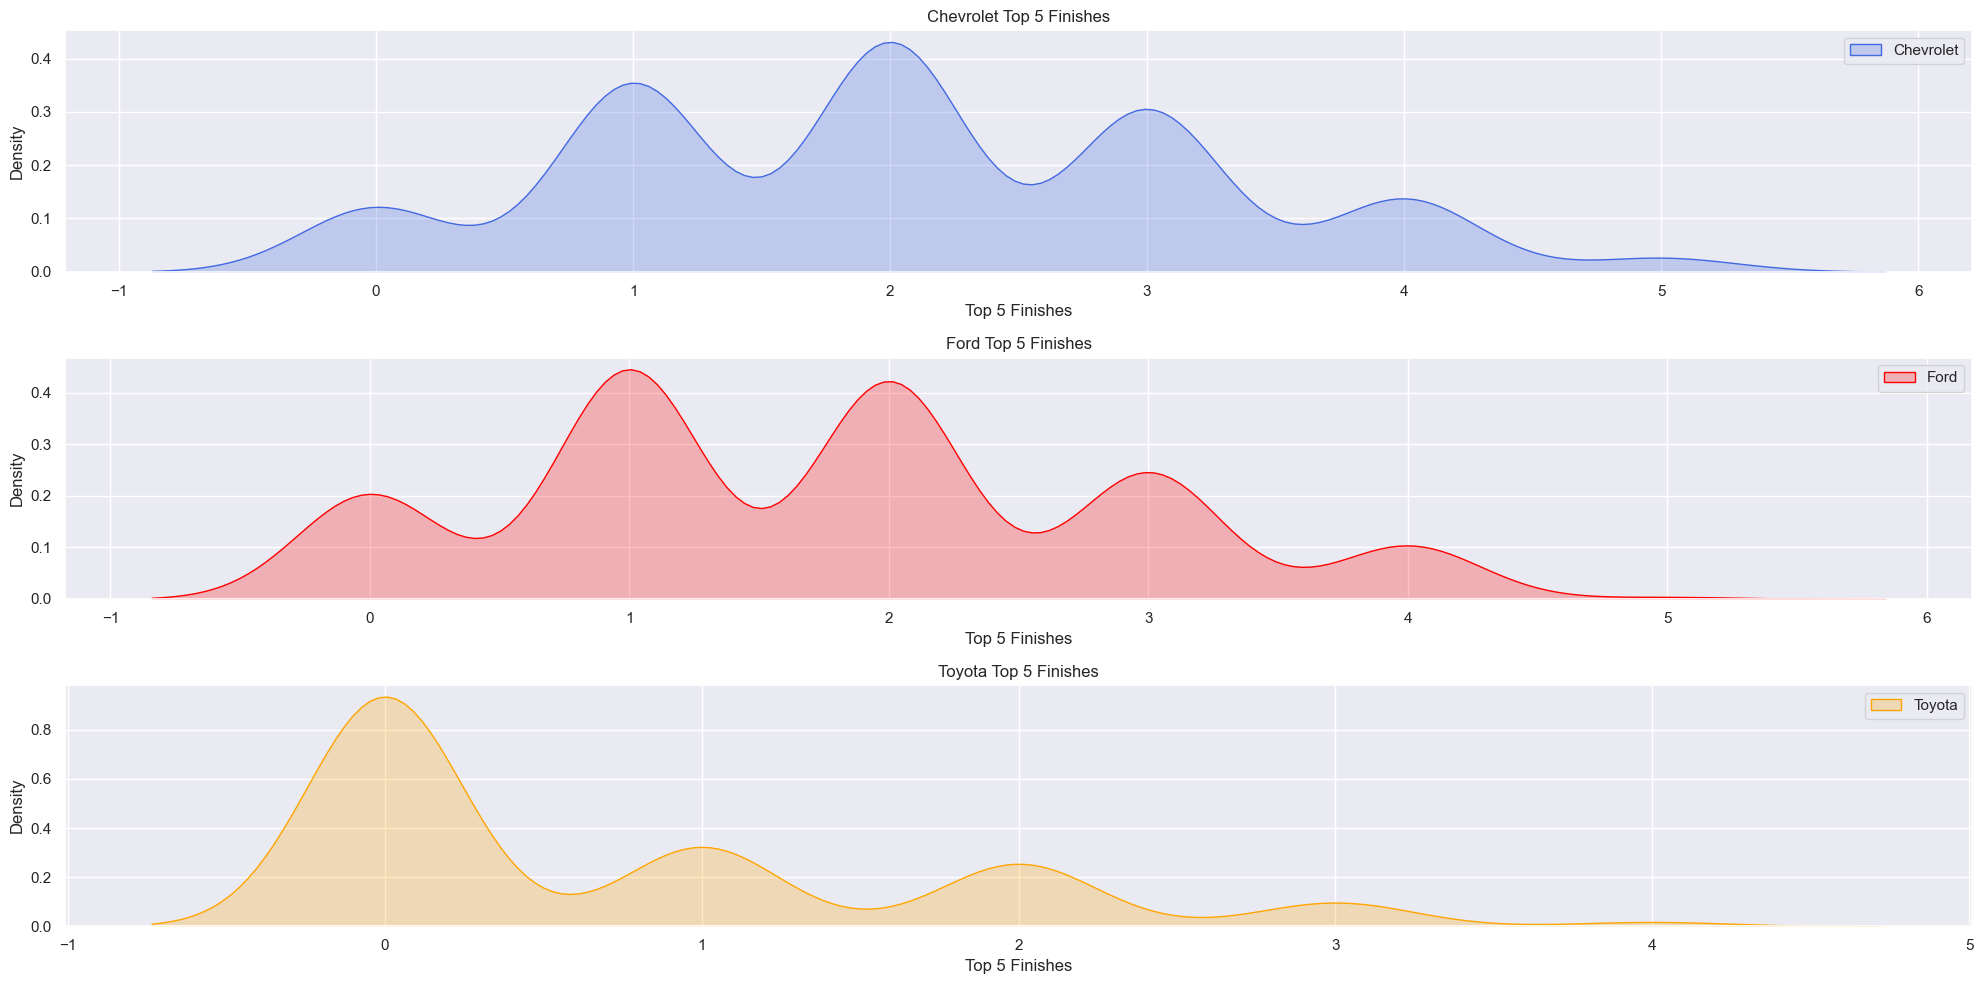

In [49]:
# Create a kde plot of the top 5 finish counts for each big 3 manufacturer (don't include Oldsmobile Pontiac, or Dodge, as they rarely appear in the top 5)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
# List of manufacturers and colors
manufacturers = [
    ('Chevrolet_top5_count', 'royalblue', 'Chevrolet'),
    ('Ford_top5_count', 'red', 'Ford'),
    ('Toyota_top5_count', 'orange', 'Toyota')
]

# Plot each KDE plot in the respective subplot
for i, (manufacturer, color, label) in enumerate(manufacturers):
    sns.kdeplot(
        race_summary[manufacturer], 
        fill=True, 
        color=color, 
        label=label, 
        ax=ax[i]
    )
    ax[i].set_title(f'{label} Top 5 Finishes')
    ax[i].set_xlabel('Top 5 Finishes')
    ax[i].set_ylabel('Density')
    ax[i].legend()

# Adjust layout to avoid overlap
fig.tight_layout()
plt.show()

In [50]:
race_summary.to_csv('../data/race_summary.csv', index=False)

In [51]:
racedate = pd.read_excel('C:/VSCode/stat425project/data/racedate.xlsx')

In [52]:
racedate = racedate[racedate['Season'] >= 1992]
racedate = racedate[racedate['Season'] <= 2023]

In [53]:
weather = weather.drop(columns=['snow'])

In [54]:
# fix the racedate date column; all the years are 2024. need to extract the year from the season column and add it to the date column

dates = racedate['Date'].astype(str).str.split('-', expand=True)
year = racedate['Season'].astype(str)
dates = year + '-' + dates[1] + '-' + dates[2]

racedate['Date'] = pd.to_datetime(dates)
racedate

,Season,Date,Track
594,1992,1992-02-16,Daytona
595,1992,1992-03-01,Rockingham
596,1992,1992-03-08,Richmond
597,1992,1992-03-15,Atlanta
598,1992,1992-03-29,Darlington
...,...,...,...
1702,2023,2023-10-08,Charlotte Roval
1703,2023,2023-10-15,Las Vegas
1704,2023,2023-10-22,Homestead
1705,2023,2023-10-29,Martinsville


In [55]:
race_summary['site'].unique()

array(['Daytona', 'Rockingham', 'Richmond', 'Atlanta', 'Darlington',
       'Bristol', 'North Wilkesboro', 'Martinsville', 'Talladega',
       'Charlotte', 'Dover', 'Sonoma', 'Pocono', 'Michigan',
       'Watkins Glen', 'Phoenix', 'Loudon', 'Indianapolis', 'Fort Worth',
       'Fontana', 'Las Vegas', 'Homestead', 'Chicago', 'Kansas',
       'Kentucky', 'Charlotte (Road)', 'Daytona (Road)', 'Bristol (Dirt)',
       'Austin', 'Nashville', 'Elkhart Lake', 'Indianapolis G.P.',
       'Gateway'], dtype=object)

In [56]:
racedate['Track'].unique()

array([' Daytona', ' Rockingham', ' Richmond', ' Atlanta', ' Darlington',
       ' Bristol', ' North Wilkesboro', ' Martinsville', ' Talladega',
       ' Charlotte', ' Dover', ' Sonoma', ' Pocono', ' Michigan',
       ' Watkins Glen', ' Phoenix', ' New Hampshire', ' Indianapolis',
       ' Texas', ' California (Auto Club)', ' Las Vegas', ' Homestead',
       ' Chicagoland', ' Kansas', ' Kentucky', ' Charlotte Roval',
       ' Daytona Road Course', ' Bristol Dirt', ' COTA', ' Nashville',
       ' Road America', ' Indy Road Course', ' Gateway (WWT)',
       ' Chicago Street'], dtype=object)

In [57]:
race_summary['site'].replace('Loudon', 'New Hampshire', inplace=True)
race_summary['site'].replace('Fort Worth', 'Texas', inplace=True)
race_summary['site'].replace('Fontana', 'California (Auto Club)', inplace=True)
race_summary['site'].replace('Chicago', 'Chicagoland', inplace=True)
race_summary['site'].replace('Charlotte (Road)', 'Charlotte Roval', inplace=True)
race_summary['site'].replace('Daytona (Road)', 'Daytona Road Course', inplace=True)
race_summary['site'].replace('Bristol (Dirt)', 'Bristol Dirt', inplace=True)
race_summary['site'].replace('Austin', 'COTA', inplace=True)
race_summary['site'].replace('Indianapolis G.P.', 'Indy Road Course', inplace=True)
race_summary['site'].replace('Elkhart Lake', 'Road America', inplace=True)
race_summary['site'].replace('Chicago Street Course', 'Chicago Street', inplace=True)
race_summary['site'].replace('Gateway', 'Gateway (WWT)', inplace=True)
race_summary.loc[race_summary['track'] == 'Chicago Street Course', 'site'] = 'Chicago Street'

racedate['Track'] = racedate['Track'].str.strip()

In [58]:
race_summary['date'] = pd.to_datetime('1/1/1992') # initialize date column to be able to compare with racedate

for season in racedate['Season'].unique():
    for site in racedate[racedate['Season'] == season]['Track'].unique():
        temp_race_summary = race_summary[(race_summary['season'] == season) & (race_summary['site'] == site)]
        print(temp_race_summary.shape[0] < racedate[(racedate['Season'] == season) & (racedate['Track'] == site)].shape[0])
    # if there is one item in race_summary and one item in racedate, then change the date in race_summary to the date in racedate
        if temp_race_summary.shape[0] == 1 and racedate[(racedate['Season'] == season) & (racedate['Track'] == site)].shape[0] == 1:
            race_summary.loc[temp_df.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[0]
    # if there is two items in race_summary and two items in racedate, then change the date of the first to the first date in racedate and the second to the second date in racedate
        elif temp_race_summary.shape[0] == 2 and racedate[(racedate['Season'] == season) & (racedate['Track'] == site)].shape[0] == 2:
            race_summary.loc[temp_race_summary.index[0], 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[0]
            race_summary.loc[temp_race_summary.index[1], 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[1]
    # if there is one item in race_summary and two items in racedate, if the race_summary date is > 
        elif temp_race_summary.shape[0] == 1 and racedate[(racedate['Season'] == season) & (racedate['Track'] == site)].shape[0] == 2:
            if season < 1997:
                if temp_race_summary['race'] <= 15:
                    # go with the first date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[0]
                else:
                    # go with the second Date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[1]
            elif season == 1997:
                if temp_race_summary['race'] <= 16:
                    # go with the first date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[0]
                else:
                    # go with the second date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[1]
            elif season < 2000:
                if temp_race_summary['race'] <= 17:
                    # go with the first date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[0]
                else:
                    # go with the second date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[1]
            else:
                if temp_race_summary['race'] <= 18:
                    # go with the first date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[0]
                else:
                    # go with the second date
                    race_summary.loc[temp_race_summary.index, 'date'] = racedate[(racedate['Season'] == season) & (racedate['Track'] == site)]['Date'].values[1]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [59]:
# merge weather on race_summary on date

weather = weather[['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'date', 'rain_binary', 'location']]

race_summary = race_summary.merge(weather, on='date', how='left')

In [60]:
# find the number of rows with no nan values without dropping any columns

# create a copy of race_summary to avoid modifying the original dataframe

copy_race_summary = race_summary.copy()

copy_race_summary.dropna().shape[0]

649

In [61]:
copy_race_summary

,season,race,site,track,track_length,track_type,laps,driver_finish_1,driver_finish_2,driver_finish_3,...,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,rain_binary,location
0,1992,1,Daytona,Daytona International Speedway,2.500,paved track,200,Davey Allison,Morgan Shepherd,Geoffrey Bodine,...,24.4,15.6,58.0,0.0,270.0,18.4,1017.7,No Rain,False,Daytona
1,1992,2,Rockingham,North Carolina Motor Speedway,1.017,paved track,492,Bill Elliott,Davey Allison,Harry Gant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992,3,Richmond,Richmond International Raceway,0.750,paved track,400,Bill Elliott,Alan Kulwicki,Harry Gant,...,13.3,10.7,84.0,0.0,240.0,0.0,1008.5,No Rain,False,Richmond
3,1992,4,Atlanta,Atlanta Motor Speedway,1.522,paved track,328,Bill Elliott,Harry Gant,Dale Earnhardt,...,15.0,-2.9,29.0,0.0,320.0,22.3,1013.9,No Rain,False,Atlanta
4,1992,5,Darlington,Darlington Raceway,1.366,paved track,367,Bill Elliott,Harry Gant,Mark Martin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,2023,32,Charlotte Roval,Charlotte Motor Speedway Road Course,2.280,road course,109,A.J. Allmendinger,William Byron,Kyle Busch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1109,2023,33,Las Vegas,Las Vegas Motor Speedway,1.500,paved track,267,Kyle Larson,Christopher Bell,Kyle Busch,...,28.6,-4.8,11.0,0.0,0.0,0.0,1016.2,No Rain,False,Las Vegas
1110,2023,34,Homestead,Homestead-Miami Speedway,1.500,paved track,267,Christopher Bell,Ryan Blaney,Tyler Reddick,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1111,2023,35,Martinsville,Martinsville Speedway,0.526,paved track,500,Ryan Blaney,Aric Almirola,Denny Hamlin,...,19.7,14.9,74.0,0.0,0.0,0.0,1021.0,No Rain,False,Martinsville


In [62]:
racedate

,Season,Date,Track
594,1992,1992-02-16,Daytona
595,1992,1992-03-01,Rockingham
596,1992,1992-03-08,Richmond
597,1992,1992-03-15,Atlanta
598,1992,1992-03-29,Darlington
...,...,...,...
1702,2023,2023-10-08,Charlotte Roval
1703,2023,2023-10-15,Las Vegas
1704,2023,2023-10-22,Homestead
1705,2023,2023-10-29,Martinsville


In [63]:
race_summary.shape[0]

1113

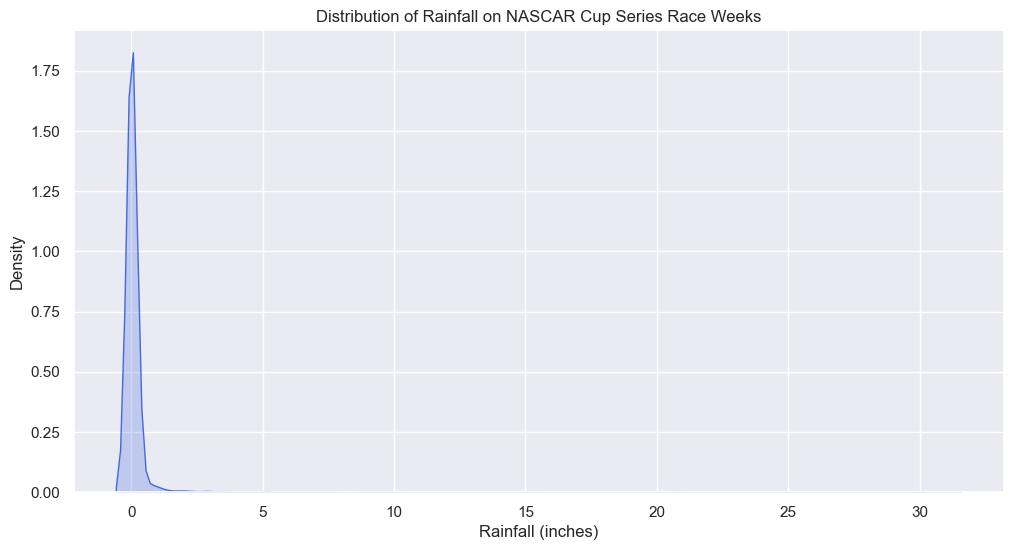

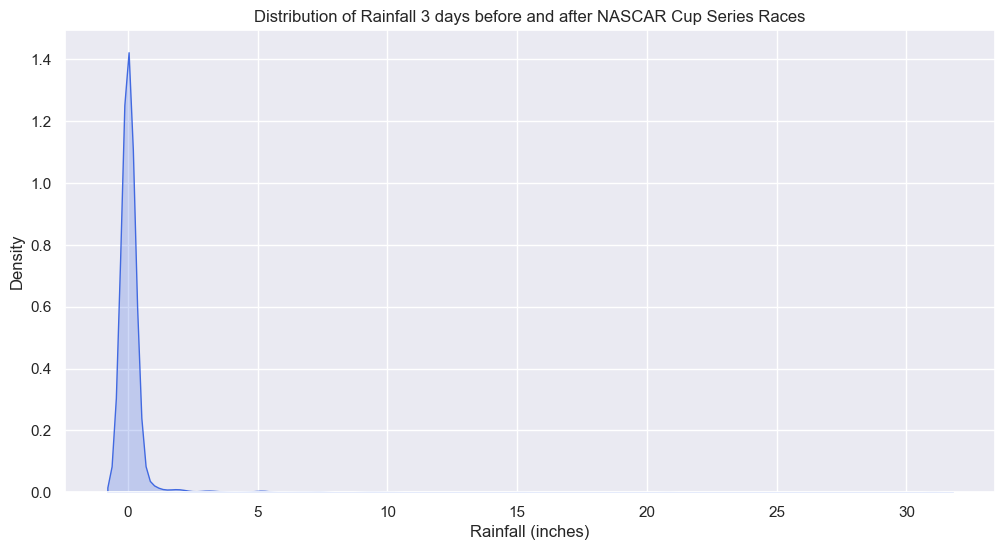

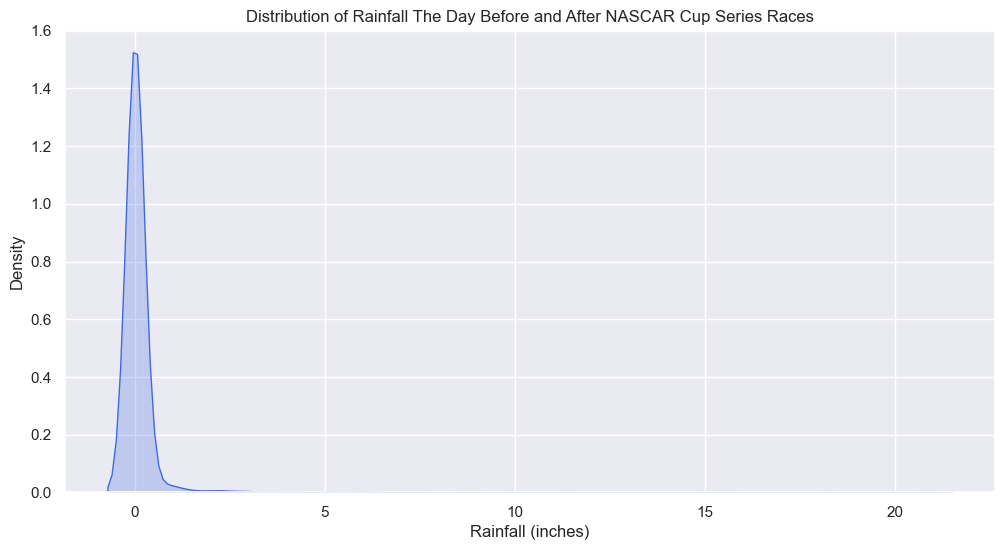

In [77]:
weather_weekly = pd.read_csv('../data/weather_weekly.csv')
weather_weekly['rain_binary'] = weather_weekly['prcp'] > 0
weather_weekly = weather_weekly[['date', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'rain_binary', 'location', 'associated_race']]
weather_weekly['date'] = pd.to_datetime(weather_weekly['date'])
# the acssociated_race column is the location combined with the date columns separated by a _. We need to split this column into two columns
weather_weekly['associated_racedate'] = weather_weekly['associated_race'].str.split('_').str[1]

weather_weekly['associated_racedate'] = pd.to_datetime(weather_weekly['associated_racedate']).dt.date

weather_weekly_without_racedate = weather_weekly[weather_weekly['associated_racedate'] != weather_weekly['date']]

# Plot the distribution of rain for the weekly weather data without the racedate

plt.figure(figsize=(12, 6))
sns.kdeplot(data=weather_weekly_without_racedate, x='prcp', fill=True, color='royalblue')
plt.title('Distribution of Rainfall on NASCAR Cup Series Race Weeks')
plt.xlabel('Rainfall (inches)')
plt.ylabel('Density')
plt.show()

# Plot the distribution of rain for 3 days before and after the races

weather_weekly_3days = weather_weekly[(weather_weekly['date'] == weather_weekly['associated_racedate'] - pd.Timedelta(days=3)) | (weather_weekly['date'] == weather_weekly['associated_racedate'] + pd.Timedelta(days=3))]
plt.figure(figsize=(12, 6))
sns.kdeplot(data=weather_weekly_3days, x='prcp', fill=True, color='royalblue')
plt.title('Distribution of Rainfall 3 days before and after NASCAR Cup Series Races')
plt.xlabel('Rainfall (inches)')
plt.ylabel('Density')
plt.show()

# Plot the distribution of rain for 1 day before and after the races

weather_weekly_1day = weather_weekly[(weather_weekly['date'] == weather_weekly['associated_racedate'] - pd.Timedelta(days=1)) | (weather_weekly['date'] == weather_weekly['associated_racedate'] + pd.Timedelta(days=1))]
plt.figure(figsize=(12, 6))
sns.kdeplot(data=weather_weekly_1day, x='prcp', fill=True, color='royalblue')
plt.title('Distribution of Rainfall The Day Before and After NASCAR Cup Series Races')
plt.xlabel('Rainfall (inches)')
plt.ylabel('Density')
plt.show()